In [6]:
import pickle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

DATA_PATH = "./cifar-10-batches-py/"
data_augmentation = False
modelName = "vggNet"

In [7]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
def show_first_samples(x_train, y_train, labels_name):
    
    for i in range(4):
        imgs = x_train[i]
        img0 = imgs[0]
        img1 = imgs[1]
        img2 = imgs[2]
        i0 = Image.fromarray(img0)
        i1 = Image.fromarray(img1)
        i2 = Image.fromarray(img2)
        img = Image.merge("RGB",(i0,i1,i2))
        plt.imshow(img)
        print(labels_name[y_train[i]])
        plt.show()

In [9]:
def load_data():
    data_first = unpickle(DATA_PATH + "data_batch_1")
    data_x = data_first[b'data']
    data_y = data_first[b'labels']
    for i in range(2,6):
        data = unpickle(DATA_PATH + f"data_batch_{i}")
        data_x = np.vstack((data_x, data[b'data']))
        data_y += data[b'labels']
    return data_x, data_y

In [10]:
def create_model():
    model = Sequential()

    model.add(Conv2D(
        filters = 64,
        kernel_size = (3,3),
        data_format = "channels_first",
        padding = "same",
        input_shape = (3, 32, 32)
        ))
    model.add(Activation('relu'))

    model.add(Conv2D(
        filters = 64,
        kernel_size = (3,3),
        data_format = "channels_first",
        padding = "same",
        input_shape = (3, 32, 32)
        ))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size = (2,2), data_format = "channels_first", padding = "same"))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128,
        kernel_size = (3,3),
        data_format = "channels_first",
        padding = "same",
    ))
    model.add(Activation('relu'))

    model.add(Conv2D(
        filters = 128,
        kernel_size = (3,3),
        data_format = "channels_first",
        padding = "same",
    ))
    

    model.add(Conv2D(
        filters = 128,
        kernel_size = (3,3),
        data_format = "channels_first",
        padding = "same",
    ))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size = (2,2), data_format = "channels_first", padding = "same"))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    return model

b'frog'


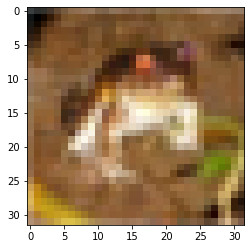

b'truck'


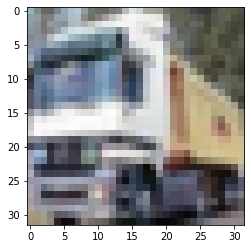

b'truck'


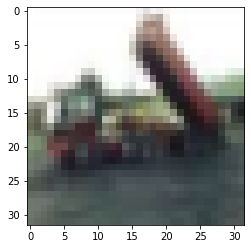

b'deer'


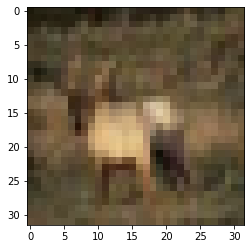

In [11]:
x_train, y_train = load_data() #load the train data cifar

data_test = unpickle(DATA_PATH + "test_batch") # load the test data
x_val, y_val = data_test[b'data'], data_test[b'labels'] 

data_info = unpickle(DATA_PATH + "batches.meta") #load the data infos
labels_name = data_info[b'label_names']

x_train = x_train.reshape(-1, 3, 32, 32)
x_val = x_val.reshape(-1, 3, 32, 32)

y_train = np.array(y_train)
y_val = np.array(y_val)

show_first_samples(x_train, y_train, labels_name)

In [12]:
x_train = x_train / 255.0
x_val = x_val / 255.0

model = create_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 32, 32)        1792      
_________________________________________________________________
activation (Activation)      (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 16, 16)       7

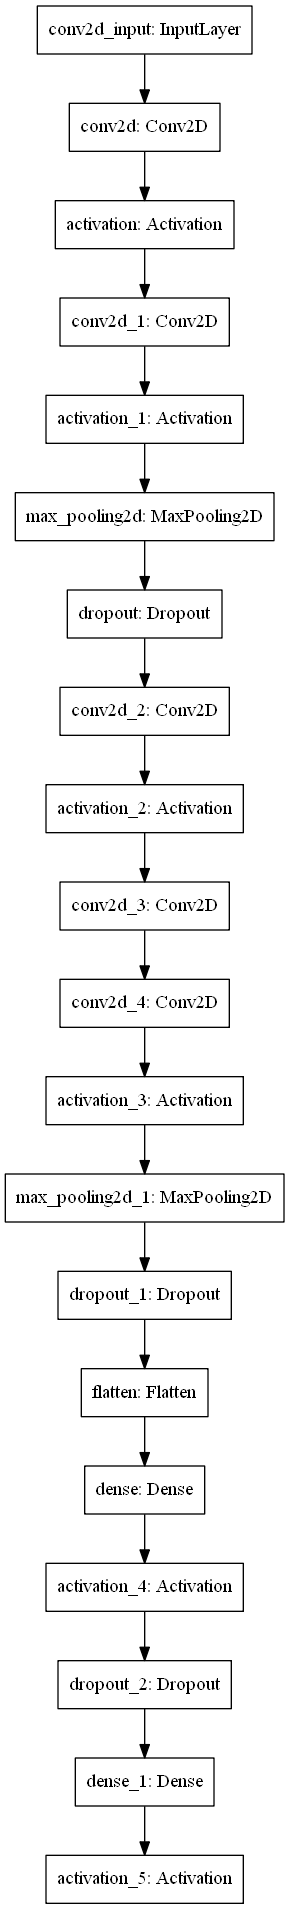

In [13]:
plot_model(model, f"{modelName}_log/{modelName}.png")

In [14]:
if data_augmentation:
    aug = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True)
    aug.fit(x_train)
    gen = aug.flow(x_train, y_train, batch_size=128)
    history = model.fit_generator(generator=gen, 
                            steps_per_epoch=50000/128, 
                            epochs=30, 
                            validation_data=(x_val, y_val),
                            callbacks=[
                                EarlyStopping(monitor="val_accuracy", patience=2),
                                TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
                                ])
else:
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
            epochs=30,
            batch_size=128,
            callbacks=[
                EarlyStopping(monitor="val_accuracy", patience=2),
                TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
                ])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 98s 2ms/sample - loss: 1.6251 - accuracy: 0.4027 - val_loss: 1.2053 - val_accuracy: 0.5721
Epoch 2/30
50000/50000 [==============================] - 119s 2ms/sample - loss: 1.1525 - accuracy: 0.5888 - val_loss: 0.9954 - val_accuracy: 0.6509
Epoch 3/30
50000/50000 [==============================] - 100s 2ms/sample - loss: 0.9506 - accuracy: 0.6656 - val_loss: 0.8103 - val_accuracy: 0.7166
Epoch 4/30
50000/50000 [==============================] - 87s 2ms/sample - loss: 0.8387 - accuracy: 0.7072 - val_loss: 0.7730 - val_accuracy: 0.7304
Epoch 5/30
50000/50000 [==============================] - 83s 2ms/sample - loss: 0.7538 - accuracy: 0.7368 - val_loss: 0.7172 - val_accuracy: 0.7497
Epoch 6/30
50000/50000 [==============================] - 75s 1ms/sample - loss: 0.6872 - accuracy: 0.7604 - val_loss: 0.6687 - val_accuracy: 0.7684
Epoch 7/30
50000/50000 [==============================

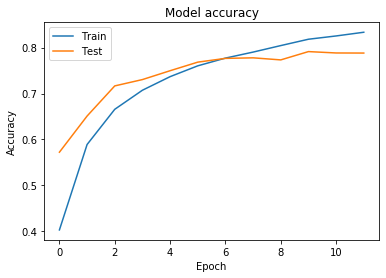

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_accuracy.png')
plt.show()

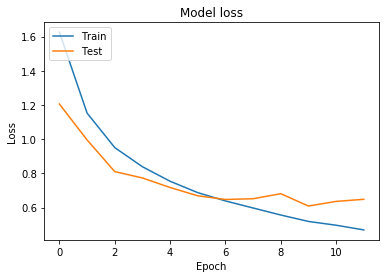

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_loss.png')
plt.show()